# 테마주 지수 만들기

In [329]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [330]:
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time

In [331]:
import FinanceDataReader as fdr

stocklst = fdr.StockListing('KRX')  # stocklst = 한국 전체 주식
stocklst.head()

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,전자부품 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,김세완,http://www.3sref.com,서울특별시
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,박대현,http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
3,054620,KOSDAQ,APS홀딩스,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도
4,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도


In [332]:
# company_lst = [
# # 장마 테마주
# # (1) 폐기물
# # 'KG ETS',
# '인선이엔티',
# '와이엔텍', 
# '제넨바이오', 
# '코엔텍',
# '그린플러스',
# '스페코'
# ]


print(len(company_lst))
company_lst



4


['위닉스', '신일전자', '파세코', '코웨이']

In [333]:
# company_lst = [
# # 열대야
# '이건산업','한솔홈데코', '자연과환경', '아시아종묘']

# print(len(company_lst))
# company_lst

In [334]:
codes_lst = stocklst[stocklst.Name.apply(lambda stock: stock in company_lst)].Symbol.to_list()  #Symbol = 코드
print(len(codes_lst)) # codes 의 길이가 company lst 의 길이가 같아야 정상적으로 나온거임 
codes_lst

4


['002700', '044340', '021240', '037070']

In [183]:
#주가 딕셔너리에 넣기-> 유가,개별 주식간 비교에 사용

price_history = dict()

for code in codes_lst:
    df = fdr.DataReader(code,'2017-01-01', '2021-12-31')
    price_history[code]= df['Close']   # 회사코드: [과거주가 리스트] 
    
df_fire = pd.DataFrame(price_history)
df_fire

,186230,013810,067900,060150,072520,029960
Date,,,,,,
2017-01-02,4716,5310,3434,6580,3555,2890
2017-01-03,4230,5400,3414,6450,3720,2900
2017-01-04,4645,5440,3399,6390,3820,2935
2017-01-05,4347,5410,3365,6530,3905,2935
2017-01-06,4690,5460,3380,6600,3840,2865
...,...,...,...,...,...,...
2021-12-24,14800,5480,10750,11100,4015,9270
2021-12-27,15100,5550,10750,11000,4040,9350
2021-12-28,14950,5570,10800,11200,3995,9280


# 테마주 지수구하기

## 페기물 주(df_index1)

In [342]:
# 지수 구하기 
driver = webdriver.Chrome()

company_lst = [
# 폐기물주
'KG ETS',
'인선이엔티',
'와이엔텍',
'코엔텍',
'스페코'
]

codes_lst = stocklst[stocklst.Name.apply(lambda stock: stock in company_lst)].Symbol.to_list()  #Symbol = 코드
# print(len(codes_lst)) # codes 의 길이가 company lst 의 길이가 같아야 정상적으로 나온거임 
# codes_lst

marketcap = dict()

for code in codes_lst:
    df_p = fdr.DataReader(code,'2015-01-01', '2017-12-31')
        
    #기준시점 시가 총액(시작날짜)
    price1 = df_p.loc['2015-01-02']['Close']
    
    url1 = 'https://navercomp.wisereport.co.kr/v2/company/c1010001.aspx?cmp_cd={}'.format(code)
    driver.get(url1)
    time.sleep(0.5)
    html1 = driver.page_source
    df1 = pd.read_html(html1)[1]
   
    # 발행 주식수
    outstanding = df1.iloc[6][1].split('/')[0]
    outstanding = outstanding.replace('주','') # 1,231,000주 -> 1,231,000
    outstanding = outstanding.replace(',', '') # 1,231,000 -> 1231000
    outstanding =  float(outstanding)
    print("발행 주식수: ",outstanding)
    
    # 유동비율 
    floating = df1.iloc[6][1].split('/')[1]
    floating = floating.replace('%', '')  # %기호 없애주기
    floating = float(floating)
    print("유동비율: ",floating)
    
     #액면가
    price_f = df1.iloc[2][1]
    price_f = price_f.replace('원', '') # 5,000원 -> 5,000
    price_f = price_f.replace(',', '') # 5,000 -> 5000
    price_f = int(price_f)
    print("액면가: ", price_f)
    print('-'* 50)
    
    ## 지수 구하기
    
    # 기업들의 주가 데이터프레임: df_p
#     df_p = fdr.DataReader(code,'2018-01-01', '2018-12-31')
    
    #비교시점의 시가총액(비교시점주가 * 발행주식수 * 유동비율)
    
    if price_f == 5000:     #액면금액이 5000원
        pass
    elif price_f == 2500:   #액면금액이 2500원
        df_p['Close'] = df_p['Close']/2
        
    elif price_f == 500:    #액면금액이 500원
        df_p['Close'] = df_p['Close']/10
        
    elif price_f == 100:    #액면금액이 100원
        df_p['Close'] = df_p['Close']/50
        
   # 회사코드 -> 회사명
    company_name = stocklst[stocklst['Symbol']== str(code)]['Name'].values[0]
    
    # 회사의 시가총액 계산
    marketcap[company_name] = df_p['Close'] * outstanding * floating   # 딕셔너리에 추가
   
 
df_index1 = pd.DataFrame(marketcap)
df_index1['total'] = df_index1.sum(axis=1)

# 기준시점 시가총액 ( 기준시점주가 * 발행주식수 * 유동비율)

marketcap_std = df_index1['total'].iloc[0]

# 지수 = (각기업시가총액합 / 2019년 1월2일의 각 기업시가총액합) * 100
df_index1['지수'] = (df_index1['total']/ marketcap_std) * 100

df_index1.reset_index(inplace=True)
df_index1.head()





    

발행 주식수:  36000000.0
유동비율:  47.9
액면가:  500
--------------------------------------------------
발행 주식수:  14655470.0
유동비율:  66.45
액면가:  500
--------------------------------------------------
발행 주식수:  18199659.0
유동비율:  52.97
액면가:  500
--------------------------------------------------
발행 주식수:  46563612.0
유동비율:  53.1
액면가:  500
--------------------------------------------------
발행 주식수:  50000000.0
유동비율:  40.29
액면가:  500
--------------------------------------------------


,Date,KG ETS,스페코,와이엔텍,인선이엔티,코엔텍,total,지수
0,2015-01-02,8.932392e+11,4.172973e+11,3.225664e+11,1.048352e+12,5.600310e+11,3.241486e+12,100.000000
1,2015-01-05,9.122076e+11,4.275228e+11,3.220844e+11,1.095330e+12,5.731252e+11,3.330270e+12,102.738996
2,2015-01-06,9.311760e+11,4.236274e+11,3.217952e+11,1.100275e+12,5.781615e+11,3.355035e+12,103.502999
3,2015-01-07,9.311760e+11,4.280097e+11,3.225664e+11,1.073077e+12,5.640600e+11,3.318889e+12,102.387902
4,2015-01-08,9.225540e+11,4.236274e+11,3.234341e+11,1.050824e+12,5.640600e+11,3.284500e+12,101.326985


## 농약, 비료주 (df_index2)

In [343]:
driver = webdriver.Chrome()

company_lst = [
# 농약, 비료주
'경농',
'조비', 
'동방아그로',
'남해화학'
]

codes_lst = stocklst[stocklst.Name.apply(lambda stock: stock in company_lst)].Symbol.to_list()  #Symbol = 코드
# print(len(codes_lst)) # codes 의 길이가 company lst 의 길이가 같아야 정상적으로 나온거임 
# codes_lst

marketcap = dict()

for code in codes_lst:
    df_p = fdr.DataReader(code,'2015-01-01', '2017-12-31')
        
    #기준시점 시가 총액(시작날짜)
    price1 = df_p.loc['2015-01-02']['Close']
    
    url1 = 'https://navercomp.wisereport.co.kr/v2/company/c1010001.aspx?cmp_cd={}'.format(code)
    driver.get(url1)
    time.sleep(0.5)
    html1 = driver.page_source
    df1 = pd.read_html(html1)[1]
   
    # 발행 주식수
    outstanding = df1.iloc[6][1].split('/')[0]
    outstanding = outstanding.replace('주','') # 1,231,000주 -> 1,231,000
    outstanding = outstanding.replace(',', '') # 1,231,000 -> 1231000
    outstanding =  float(outstanding)
    print("발행 주식수: ",outstanding)
    
    # 유동비율 
    floating = df1.iloc[6][1].split('/')[1]
    floating = floating.replace('%', '')  # %기호 없애주기
    floating = float(floating)
    print("유동비율: ",floating)
    
     #액면가
    price_f = df1.iloc[2][1]
    price_f = price_f.replace('원', '') # 5,000원 -> 5,000
    price_f = price_f.replace(',', '') # 5,000 -> 5000
    price_f = int(price_f)
    print("액면가: ", price_f)
    print('-'* 50)
    
    ## 지수 구하기
    
    # 기업들의 주가 데이터프레임: df_p
#     df_p = fdr.DataReader(code,'2018-01-01', '2018-12-31')
    
    #비교시점의 시가총액(비교시점주가 * 발행주식수 * 유동비율)
    
    if price_f == 5000:     #액면금액이 5000원
        pass
    elif price_f == 2500:   #액면금액이 2500원
        df_p['Close'] = df_p['Close']/2
        
    elif price_f == 500:    #액면금액이 500원
        df_p['Close'] = df_p['Close']/10
        
    elif price_f == 100:    #액면금액이 100원
        df_p['Close'] = df_p['Close']/50
        
   # 회사코드 -> 회사명
    company_name = stocklst[stocklst['Symbol']== str(code)]['Name'].values[0]
    
    # 회사의 시가총액 계산
    marketcap[company_name] = df_p['Close'] * outstanding * floating   # 딕셔너리에 추가
   
 
df_index2 = pd.DataFrame(marketcap)
df_index2['total'] = df_index2.sum(axis=1)

# 기준시점 시가총액 ( 기준시점주가 * 발행주식수 * 유동비율)

marketcap_std = df_index2['total'].iloc[0]

# 지수 = (각기업시가총액합 / 2019년 1월2일의 각 기업시가총액합) * 100
df_index2['지수'] = (df_index2['total']/ marketcap_std) * 100

df_index2.reset_index(inplace=True)
df_index2.head()


발행 주식수:  19522575.0
유동비율:  23.24
액면가:  500
--------------------------------------------------
발행 주식수:  49678843.0
유동비율:  40.52
액면가:  1000
--------------------------------------------------
발행 주식수:  13617577.0
유동비율:  54.89
액면가:  500
--------------------------------------------------
발행 주식수:  5192239.0
유동비율:  43.04
액면가:  5000
--------------------------------------------------


,Date,경농,남해화학,동방아그로,조비,total,지수
0,2015-01-02,2.191393e+11,1.882143e+13,4.761376e+11,2.748730e+12,2.226543e+13,100.000000
1,2015-01-05,2.180051e+11,1.868052e+13,4.761376e+11,2.737556e+12,2.211222e+13,99.311861
2,2015-01-06,2.173245e+11,1.823766e+13,4.694104e+11,2.692861e+12,2.161726e+13,97.088866
3,2015-01-07,2.200468e+11,1.813701e+13,4.686629e+11,2.692861e+12,2.151858e+13,96.645692
4,2015-01-08,2.200468e+11,1.847922e+13,4.686629e+11,2.715209e+12,2.188314e+13,98.283006


## 제습기 주

In [344]:
driver = webdriver.Chrome()

company_lst = [
# 제습기 주
'위닉스',
'신일전자',
'파세코',
'코웨이'
]

codes_lst = stocklst[stocklst.Name.apply(lambda stock: stock in company_lst)].Symbol.to_list()  #Symbol = 코드
# print(len(codes_lst)) # codes 의 길이가 company lst 의 길이가 같아야 정상적으로 나온거임 
# codes_lst

marketcap = dict()

for code in codes_lst:
    df_p = fdr.DataReader(code,'2015-01-01', '2017-12-31')
        
    #기준시점 시가 총액(시작날짜)
    price1 = df_p.loc['2015-01-02']['Close']
    
    url1 = 'https://navercomp.wisereport.co.kr/v2/company/c1010001.aspx?cmp_cd={}'.format(code)
    driver.get(url1)
    time.sleep(0.5)
    html1 = driver.page_source
    df1 = pd.read_html(html1)[1]
   
    # 발행 주식수
    outstanding = df1.iloc[6][1].split('/')[0]
    outstanding = outstanding.replace('주','') # 1,231,000주 -> 1,231,000
    outstanding = outstanding.replace(',', '') # 1,231,000 -> 1231000
    outstanding =  float(outstanding)
    print("발행 주식수: ",outstanding)
    
    # 유동비율 
    floating = df1.iloc[6][1].split('/')[1]
    floating = floating.replace('%', '')  # %기호 없애주기
    floating = float(floating)
    print("유동비율: ",floating)
    
     #액면가
    price_f = df1.iloc[2][1]
    price_f = price_f.replace('원', '') # 5,000원 -> 5,000
    price_f = price_f.replace(',', '') # 5,000 -> 5000
    price_f = int(price_f)
    print("액면가: ", price_f)
    print('-'* 50)
    
    ## 지수 구하기
    
    # 기업들의 주가 데이터프레임: df_p
#     df_p = fdr.DataReader(code,'2018-01-01', '2018-12-31')
    
    #비교시점의 시가총액(비교시점주가 * 발행주식수 * 유동비율)
    
    if price_f == 5000:     #액면금액이 5000원
        pass
    elif price_f == 2500:   #액면금액이 2500원
        df_p['Close'] = df_p['Close']/2
        
    elif price_f == 500:    #액면금액이 500원
        df_p['Close'] = df_p['Close']/10
        
    elif price_f == 100:    #액면금액이 100원
        df_p['Close'] = df_p['Close']/50
        
   # 회사코드 -> 회사명
    company_name = stocklst[stocklst['Symbol']== str(code)]['Name'].values[0]
    
    # 회사의 시가총액 계산
    marketcap[company_name] = df_p['Close'] * outstanding * floating   # 딕셔너리에 추가
   
 
df_index3 = pd.DataFrame(marketcap)
df_index3['total'] = df_index3.sum(axis=1)

# 기준시점 시가총액 ( 기준시점주가 * 발행주식수 * 유동비율)

marketcap_std = df_index3['total'].iloc[0]

# 지수 = (각기업시가총액합 / 2019년 1월2일의 각 기업시가총액합) * 100
df_index3['지수'] = (df_index3['total']/ marketcap_std) * 100

df_index3.reset_index(inplace=True)
df_index3.head()


발행 주식수:  71047521.0
유동비율:  82.68
액면가:  500
--------------------------------------------------
발행 주식수:  17873425.0
유동비율:  40.52
액면가:  500
--------------------------------------------------
발행 주식수:  73799619.0
유동비율:  73.21
액면가:  500
--------------------------------------------------
발행 주식수:  20000000.0
유동비율:  28.22
액면가:  500
--------------------------------------------------


,Date,신일전자,위닉스,코웨이,파세코,total,지수
0,2015-01-02,8.341377e+11,1.042893e+12,4.592440e+13,2.295979e+11,4.803102e+13,100.000000
1,2015-01-05,8.400119e+11,1.021166e+12,4.560022e+13,2.303316e+11,4.769173e+13,99.293600
2,2015-01-06,8.370748e+11,1.046514e+12,4.457368e+13,2.351855e+11,4.669245e+13,97.213110
3,2015-01-07,8.400119e+11,1.202224e+12,4.354713e+13,2.404344e+11,4.582980e+13,95.417084
4,2015-01-08,8.605716e+11,1.231193e+12,4.262865e+13,2.385154e+11,4.495893e+13,93.603927


# 지수변동률 추가

In [336]:
# 지수변동률 추가

# diff_lst = [0]
# for i in range(len(df_marketcap)-1):
#     diff = (df_marketcap['지수'].iloc[i+1]-df_marketcap['지수'].iloc[i])*100/df_marketcap['지수'].iloc[i]
#     diff_lst.append(diff)
# len(diff_lst)

# df_marketcap['지수변동률'] = diff_lst
# df_marketcap.reset_index(inplace=True)
# df_marketcap.head(2)

In [337]:
# df_scaler = df_marketcap.copy()
# df_scaler.head(2)

# 시각화

In [338]:
## 비율 맞춰주기
# # scaler 쓰려면 데이터타입이 모두 같아야 해서 Date 없애주는 과정

# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# scaler = MinMaxScaler()

# # 날짜 없애고 표준화 값으로 새로운 데이터프레임 생성
# df_scaler1 = df_scaler.drop('Date',axis =1)
# df_scaled = pd.DataFrame(scaler.fit_transform(df_scaler1))
# df_scaled

In [339]:
# price_history = dict()

# for code in codes_lst:
#     df = fdr.DataReader(code,'2018-01-01', '2018-12-31')
    
#     company_name = stocklst[stocklst['Symbol']== str(code)]['Name'].values[0]

#     price_history[str(company_name)]= df['Close']   # 회사코드: [과거주가 리스트] 
    
# df_p = pd.DataFrame(price_history)
# df_p

In [346]:
len(x)

737

In [349]:
len(y3)

737

## matplotlib

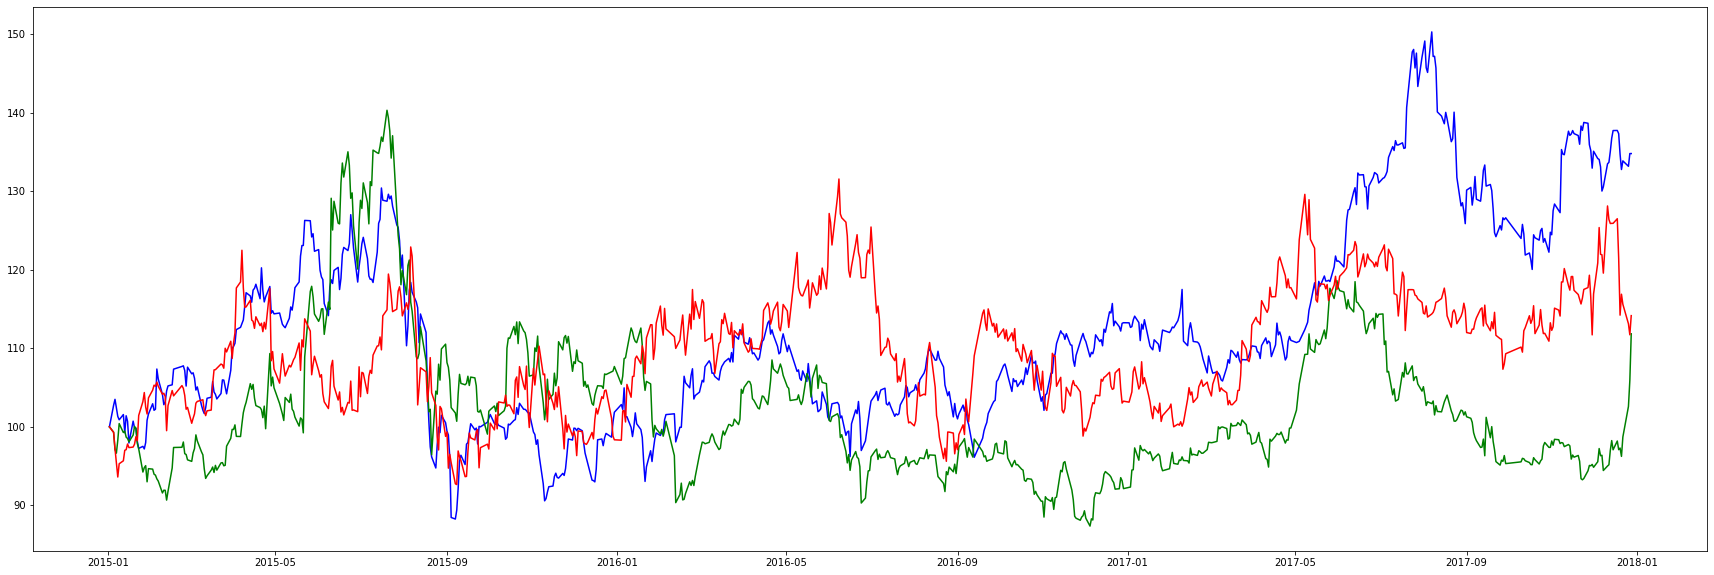

In [350]:
x = df_index1['Date']
y1 = df_index1['지수']
y2 = df_index2['지수']
y3 = df_index3['지수']
plt.figure(figsize=(30,10))
plt.plot(x,y1,'b', x,y2,'g',x,y3,'r')


# y1_scaled = df_scaled.iloc[:,-1]
# y2_scaled = df_scaled.iloc[:,-2]

## plotly

In [351]:
# plotly
# 그래프 하나로 만들기
df_total = pd.DataFrame({'Date': df_index1['Date'], '폐기물_지수':df_index1['지수'],'농약비료_지수':df_index2['지수'],'제습기_지수':df_index3['지수']})

fig = px.line(df_total, x='Date', y=['폐기물_지수','농약비료_지수','제습기_지수'])
fig.update_xaxes(rangeslider_visible=True)
fig.show()                

## 개별 주식의 추세

In [318]:

stocklst = fdr.StockListing('KRX')
company_lst = [
# 장마 테마주
# (1) 폐기물: 2011년 7월 27일 부근 변동성 큰 주식
'KG ETS',
'인선이엔티',
'와이엔텍',
'코엔텍',
'스페코'

]
codes_lst = stocklst[stocklst.Name.apply(lambda stock: stock in company_lst)].Symbol.to_list() 


price_history = dict()

for code in codes_lst:
    df = fdr.DataReader(code,'2016-01-01', '2018-12-31')
    price_history[code]= df['Close']   # 회사코드: [과거주가 리스트] 
    company_name = stocklst[stocklst['Symbol']== str(code)]['Name'].values[0]
    print('회사이름: ',company_name , '회사코드: ',str(code) )
        
df_p = pd.DataFrame(price_history)
df_p.reset_index(inplace=True)

# 코드 문자열로 바꿔주기
code_str = list(map(str,codes_lst))

fig = px.line(df_p, x='Date', y= code_str)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

회사이름:  KG ETS 회사코드:  151860
회사이름:  스페코 회사코드:  013810
회사이름:  와이엔텍 회사코드:  067900
회사이름:  인선이엔티 회사코드:  060150
회사이름:  코엔텍 회사코드:  029960


In [243]:
#주가 딕셔너리에 넣기-> 유가,개별 주식간 비교에 사용

stocklst = fdr.StockListing('KRX')
company_lst = [
# 장마 테마주
# (2) 농약비료
'경농' ,
# '조비' ,
'동방아그로',
# '남해화학'
]
codes_lst = stocklst[stocklst.Name.apply(lambda stock: stock in company_lst)].Symbol.to_list() 


price_history = dict()

for code in codes_lst:
    df = fdr.DataReader(code,'2011-01-01', '2011-12-31')
    price_history[code]= df['Close']   # 회사코드: [과거주가 리스트] 
    company_name = stocklst[stocklst['Symbol']== str(code)]['Name'].values[0]
    print('회사이름: ',company_name , '회사코드: ',str(code) )
        
df_p = pd.DataFrame(price_history)
df_p.reset_index(inplace=True)

# 코드 문자열로 바꿔주기
code_str = list(map(str,codes_lst))

fig = px.line(df_p, x='Date', y= code_str)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

회사이름:  경농 회사코드:  002100
회사이름:  동방아그로 회사코드:  007590


In [ ]:
'KG ETS',
'인선이엔티',

=장마
- 폐기물 관련주
'KG ETS'
'인선이엔티'
'와이엔텍' 
# '제넨바이오' *
# '코엔텍'
# '그린플러스' *
'스페코'
'태영건설'

 - 농약/비료
'경농' *
'조비' 
'동방아그로' *
'남해화학'
백광소재
효성오앤비

- 제습기
위닉스
신일전자
파세코
코웨이


남해화학 동방아그로 조비 
파루 경농



= 가뭄
뉴보텍 - 상하수관 및 하수정비

동양철관 - 수도관 및 배관용 장비 제조 및 판매

뉴로스 - 상하수도 및 수처리

자연과환경 - 4대강 관련주

CSA코믹스 - 수처리

웰크론한텍 - 폐수처리 및 담수처리 전문업체


열대야 테마주 
'신일전자'
'파세코'
'에스씨디'
'빙그레'
'위닉스'
'태경케미컬'
'위니아딤채'
'에스피지'
'롯데하이마트'
'비엠티'

## 코스피, 코스닥 지수

In [307]:
# df_index = fdr.DataReader('KS100','2019-01-01','2019-12-31') 왜 안될까

## 다음날 아침 급등주 캐치 전략

In [75]:
df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2019-01-02,5760,5880,5650,5650,22922,-0.013962
2019-01-03,5650,5900,5620,5730,37716,0.014159
2019-01-04,5770,5770,5590,5690,37358,-0.006981
2019-01-07,5730,5870,5700,5800,35747,0.019332
2019-01-08,5940,6340,5860,6200,178631,0.068966


In [78]:
# 전날 종가 다음날 고가 변동률

diff_history = dict()

for code in codes_fire:
    df = fdr.DataReader(code,'2019-01-02', '2019-12-31')
    diff_history[code]= df['Change']   # 회사코드: [과거주가 리스트] 

df_diff = pd.DataFrame(diff_history)
df_diff

,014200,067170,074610,083640,033540,010040,041440
Date,,,,,,,
2019-01-02,0.000000,0.023810,-0.038869,0.000000,0.018182,-0.059783,-0.013962
2019-01-03,0.000000,0.013953,0.000000,-0.047945,-0.023214,0.021195,0.014159
2019-01-04,0.024048,0.036697,0.042279,0.017986,-0.018282,-0.001887,-0.006981
2019-01-07,-0.007828,0.000000,0.169312,0.000000,0.018622,0.068053,0.019332
2019-01-08,0.001972,0.013274,-0.072398,0.028269,0.012797,-0.017699,0.068966
...,...,...,...,...,...,...,...
2019-12-23,-0.017429,0.017937,-0.035135,-0.036918,0.030635,-0.025579,-0.002227
2019-12-24,-0.024390,-0.008811,-0.008403,-0.031111,-0.010616,-0.020000,-0.006696
2019-12-26,0.031818,0.017778,0.032486,0.028670,-0.017167,0.019133,-0.004494


In [ ]:
# 구제역 관련주
# 대체식품(수산업,닭)
: 한성기업,정다운,동우팜투테이블,사조오양, 
신라교역, 마니커, 동원산업 
신라에스지 
하림 
동원수산 
이지홀딩스
팜스토리


# 사료
한일사료

# 백신
우성사료 우진비앤지 대성미생물 

# 석회
태경비케이 



In [ ]:
# ai 관련주(주로 백신) : ai가 길어지면 대체식품주 오를 수 있음

파루
제일바이오
이글벳
진원생명과학
팜스웰바이오
씨티씨바이오
대한뉴팜

